# Recursive Forecasting with ML & skforecast 
Conda environment: `time-series`   
12 May 2024  

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

from skforecast.ForecasterAutoreg import ForecasterAutoreg

In [2]:
# Configs

# Plot configs:
sns.set_context("paper", font_scale= 1.5)
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plotsize = (22, 5)
plt.rcParams['figure.figsize'] = plotsize

# Pandas config
pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.max_columns = 200

## 1) Input data

In [3]:
# Electricity demand.
url = "https://raw.githubusercontent.com/tidyverts/tsibbledata/master/data-raw/vic_elec/VIC2015/demand.csv"
df = pd.read_csv(url)

df.drop(columns=["Industrial"], inplace=True)

# Convert the integer Date to an actual date with datetime type
df["date"] = df["Date"].apply(
    lambda x: pd.Timestamp("1899-12-30") + pd.Timedelta(x, unit="days")
)

# Create a timestamp from the integer Period representing 30 minute intervals
df["date_time"] = df["date"] + \
    pd.to_timedelta((df["Period"] - 1) * 30, unit="m")

df.dropna(inplace=True)

# Rename columns
df = df[["date_time", "OperationalLessIndustrial"]]

df.columns = ["date_time", "demand"]

# Resample to hourly
df = (
    df.set_index("date_time")
    .resample("H")
    .agg({"demand": "sum"})
)

df

,demand
date_time,
2002-01-01 00:00:00,"6,919.3661"
2002-01-01 01:00:00,"7,165.9742"
2002-01-01 02:00:00,"6,406.5430"
2002-01-01 03:00:00,"5,815.5378"
2002-01-01 04:00:00,"5,497.7329"
...,...
2015-02-28 19:00:00,"9,596.7771"
2015-02-28 20:00:00,"8,883.2303"
2015-02-28 21:00:00,"8,320.2605"


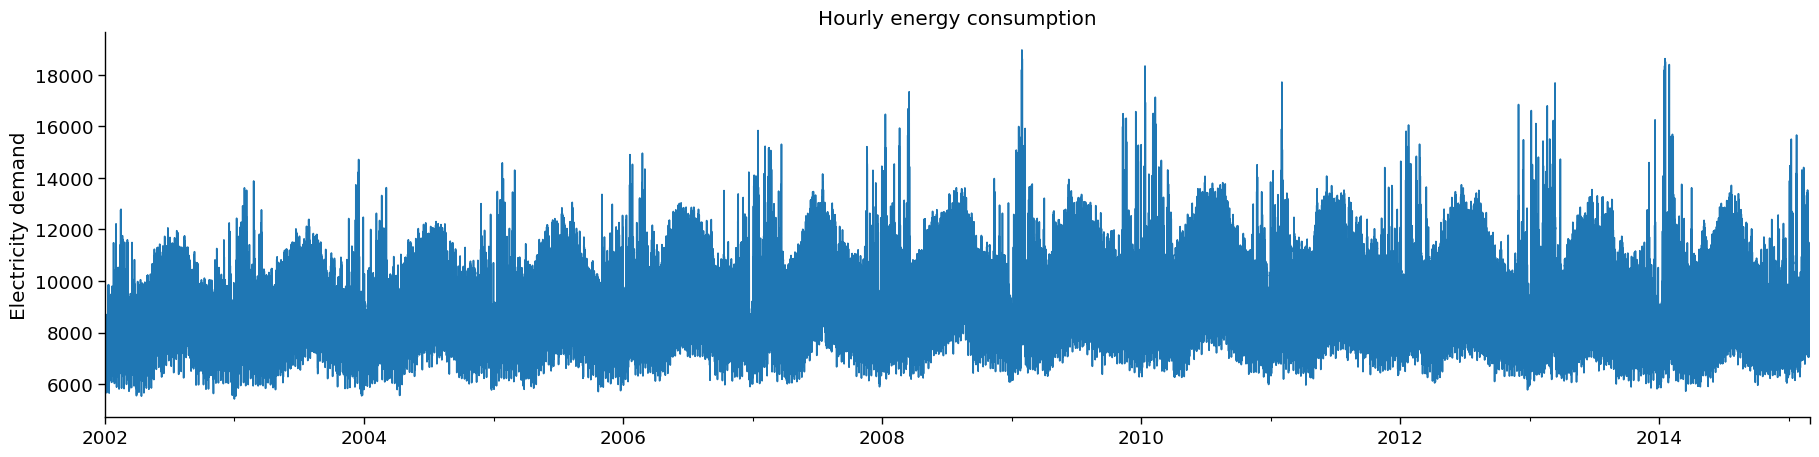

In [4]:
df.plot(legend=None)

plt.title("Hourly energy consumption")
plt.ylabel("Electricity demand")
plt.xlabel("")
plt.show()

## 2) Train/Test split

In [5]:
end_train = '2014-12-31 23:59:59'
X_train = df.loc[:end_train]
X_test  = df.loc[end_train:]

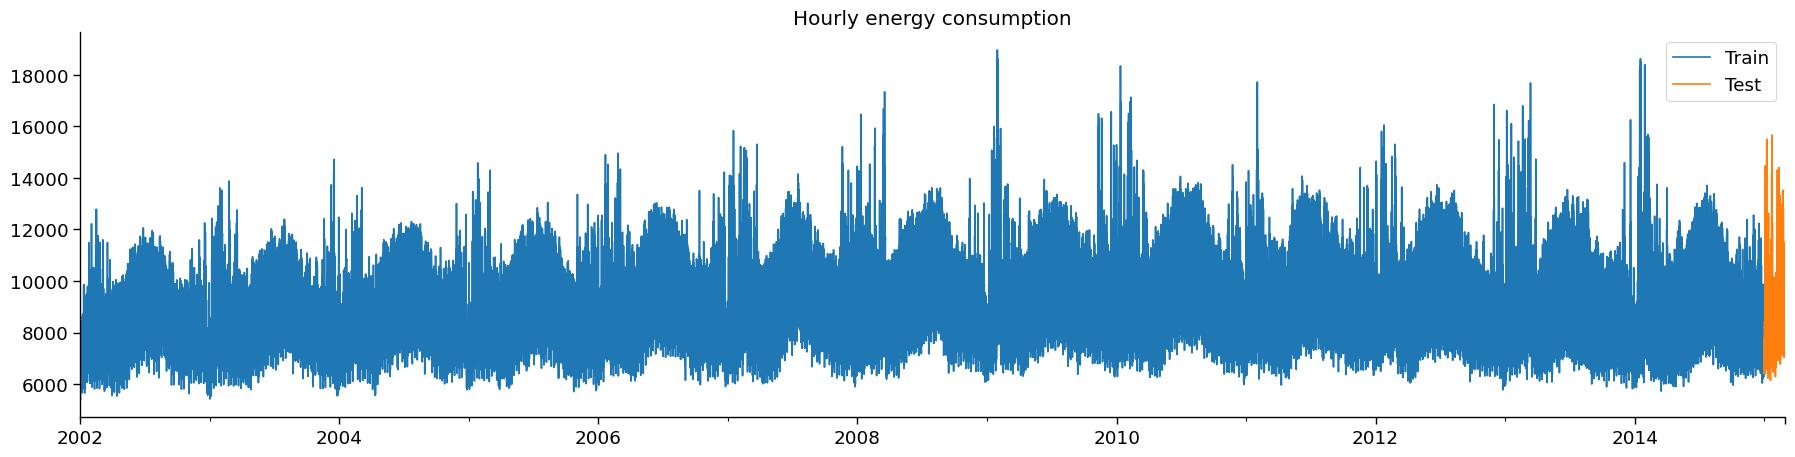

In [6]:
fig, ax=plt.subplots()

X_train.plot(ax=ax, label="Train")
X_test.plot(ax=ax, label="Test")

ax.set_title("Hourly energy consumption")
ax.set_xlabel("")
ax.legend(["Train", "Test"])
plt.show()

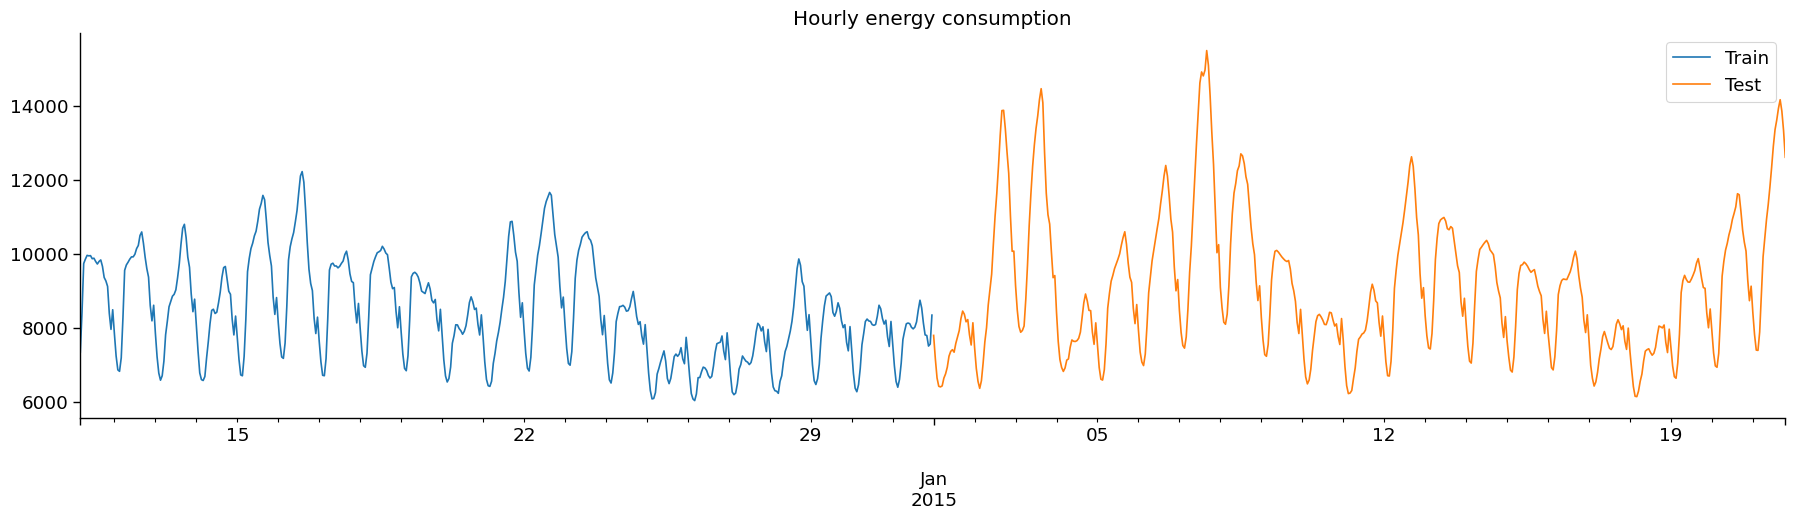

In [7]:
fig, ax = plt.subplots()

X_train.tail(500).plot(ax=ax)
X_test.head(500).plot(ax=ax)

ax.set_title("Hourly energy consumption")
ax.set_xlabel("")
ax.legend(["Train", "Test"])
plt.show()

## 3) Forecast

In [8]:
lasso = Lasso(random_state=9)

# Window size: means the number of values needed to forecast
forecaster = ForecasterAutoreg(
    regressor=lasso,            
    lags=[1, 24, 6*24],  # the lag features to create. If we pass an integer, i.e. 24 ForecasterAutoreg will create lags from 1 to 24.
    forecaster_id="recursive" # name
)

# Fit the Lasso model
forecaster.fit(y=X_train["demand"])

# Print
forecaster

ForecasterAutoreg 
Regressor: Lasso(random_state=9) 
Lags: [  1  24 144] 
Transformer for y: None 
Transformer for exog: None 
Window size: 144 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2002-01-01 00:00:00'), Timestamp('2014-12-31 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': 9, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2024-05-12 18:55:32 
Last fit date: 2024-05-12 18:55:32 
Skforecast version: 0.11.0 
Python version: 3.11.6 
Forecaster id: recursive 

In [9]:
HORIZON = 24

predictions = forecaster.predict(steps= HORIZON)
pd.DataFrame(predictions).reset_index().rename(columns={"index": "date"})

,date,pred
0,2015-01-01 00:00:00,"8,063.2791"
1,2015-01-01 01:00:00,"7,683.1683"
2,2015-01-01 02:00:00,"7,270.4109"
3,2015-01-01 03:00:00,"6,918.7415"
4,2015-01-01 04:00:00,"6,684.2402"
5,2015-01-01 05:00:00,"6,601.6578"
6,2015-01-01 06:00:00,"6,697.2235"
7,2015-01-01 07:00:00,"6,806.1114"
8,2015-01-01 08:00:00,"6,938.2291"
9,2015-01-01 09:00:00,"7,055.8196"


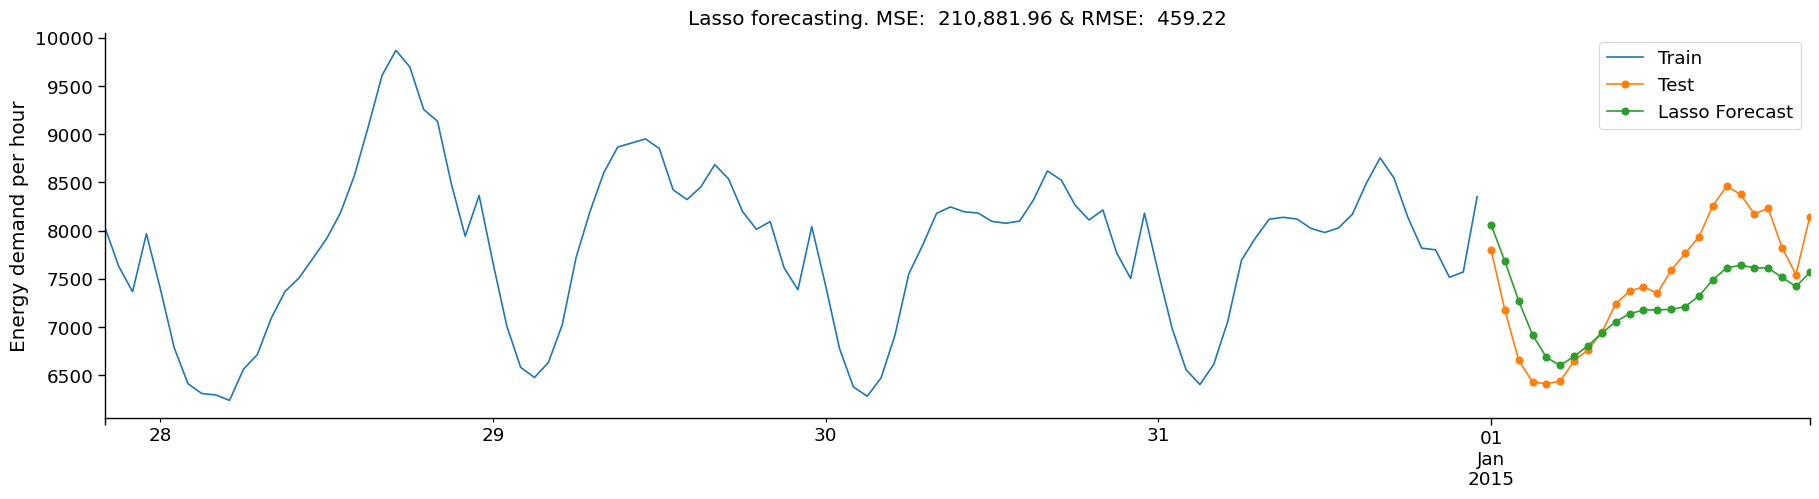

In [10]:
# MSE
error_mse = mean_squared_error(
                y_true = X_test["demand"].loc[predictions.index] , 
                y_pred = predictions,
                squared=True,
            )
# RMSE 
error_rmse = mean_squared_error(
                y_true = X_test["demand"].loc[predictions.index], 
                y_pred = predictions,
                squared=False,
            )

fig, ax = plt.subplots()

X_train.tail(100).plot(ax=ax)
X_test.head(24).plot(ax=ax, marker="o")
predictions.plot(ax=ax, marker="o")

ax.legend(["Train", "Test", "Lasso Forecast"])
plt.title(f"Lasso forecasting. MSE: {error_mse: ,.2f} & RMSE: {error_rmse: ,.2f}")
plt.ylabel("Energy demand per hour")
plt.xlabel("")

plt.show()

## 4) Predict any time point in the future

Say we want to predict energy demand later in the future with the model we just trained. First, we need to gather the data necessary to create the lags (144 data points).    
Then, pass that past data to the forecaster.

In [11]:
forecaster.window_size

144

In [13]:
# Say we want to predict energy demand for 1st of February
forecast_start = '2015-02-01 00:00:00'

# We need the energy demand up to 144 hs before that point
past_data_available = X_test[:'2015-01-31 23:59:59'].tail(144)
past_data_available

,demand
date_time,
2015-01-26 00:00:00,"7,492.9846"
2015-01-26 01:00:00,"6,991.4994"
2015-01-26 02:00:00,"6,595.5844"
2015-01-26 03:00:00,"6,469.6956"
2015-01-26 04:00:00,"6,597.0293"
...,...
2015-01-31 19:00:00,"8,441.9289"
2015-01-31 20:00:00,"8,391.3746"
2015-01-31 21:00:00,"7,949.1561"


In [14]:
# Forecast next 24 hs starting Feb 2015
predictions = forecaster.predict(
    steps=HORIZON, 
    last_window=past_data_available["demand"], # we pass the data up to Feb 2015
)

# Show predictions
pd.DataFrame(predictions).reset_index().rename(columns={"index": "date"})

,date,pred
0,2015-02-01 00:00:00,"8,129.1748"
1,2015-02-01 01:00:00,"7,795.5619"
2,2015-02-01 02:00:00,"7,420.6372"
3,2015-02-01 03:00:00,"7,102.8286"
4,2015-02-01 04:00:00,"6,903.2074"
5,2015-02-01 05:00:00,"6,848.1954"
6,2015-02-01 06:00:00,"6,934.4030"
7,2015-02-01 07:00:00,"7,072.4827"
8,2015-02-01 08:00:00,"7,268.5742"
9,2015-02-01 09:00:00,"7,450.7924"


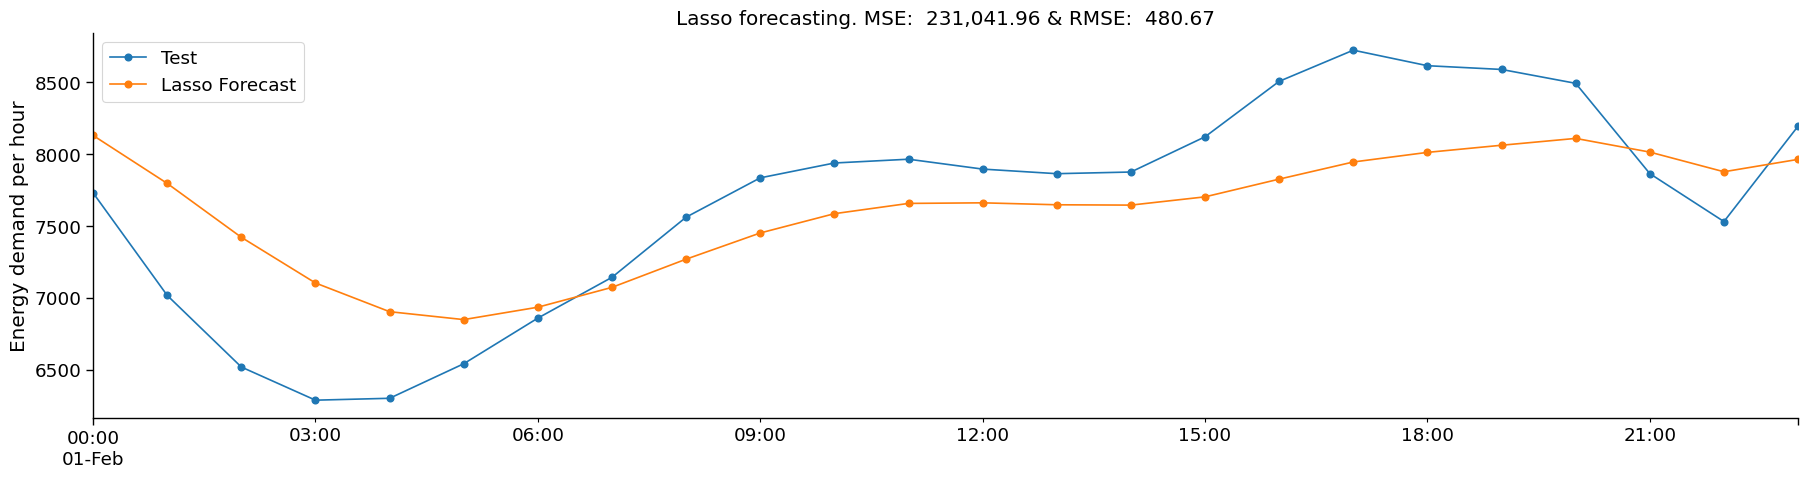

In [15]:
# MSE
error_mse = mean_squared_error(
                y_true = X_test["demand"].loc[predictions.index] , 
                y_pred = predictions,
                squared=True,
            )
# RMSE 
error_rmse = mean_squared_error(
                y_true = X_test["demand"].loc[predictions.index], 
                y_pred = predictions,
                squared=False,
            )

fig, ax = plt.subplots()

X_test["2015-01-31 23:59:59":].head(HORIZON).plot(ax=ax, marker="o")
predictions.plot(ax=ax, marker="o")

ax.legend(["Test", "Lasso Forecast"])
plt.title(f"Lasso forecasting. MSE: {error_mse: ,.2f} & RMSE: {error_rmse: ,.2f}")
plt.ylabel("Energy demand per hour")
plt.xlabel("")

plt.show()